In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import time
from typing import Callable, Union

In [2]:
x = sp.symbols("x")
y = sp.symbols("y")

f = 100 * (y - x**2)**2 + (1-x)**2
f.diff(y).diff(x)

-400*x

In [6]:
def rosenbrock(X, return_derivatives: bool = True):
    x1, x2 = X
    f = 100 * (x2 - x1**2)**2 + (1 - x1)**2

    if return_derivatives:
        df = np.array([-400*x1*(x2 - x1**2) + 2 * x1 - 2, 200*(x2 - x1 ** 2)])
        ddf = np.array([[1200*x1 ** 2 - 400*x2+2, -400*x1],[-400*x1,200*np.ones_like(x1)]])
        return f, df, ddf
    return f

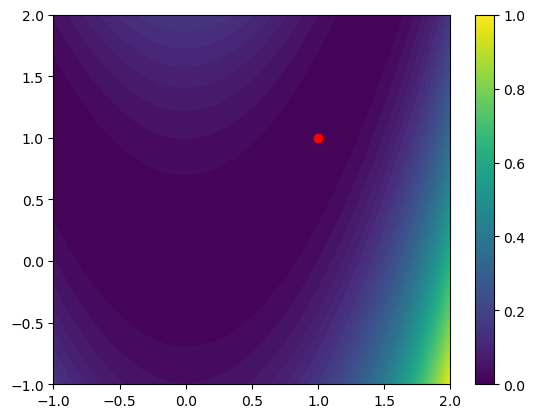

In [61]:
x = np.linspace(-1, 2, 1000)
y = np.linspace(-1, 2, 1000)

X, Y = np.meshgrid(x, y)

Z, _, _ = rosenbrock([X, Y], return_derivatives=True)

plt.contourf(X, Y, Z, levels=50)
plt.scatter([1],[1], color="red")
plt.colorbar()
plt.show()

C:\Users\rasmu\AppData\Local\Temp\ipykernel_15940\229802358.py:1: RuntimeWarning: divide by zero encountered in log
  plt.contourf(X,Y,np.log((Z)), levels=50)


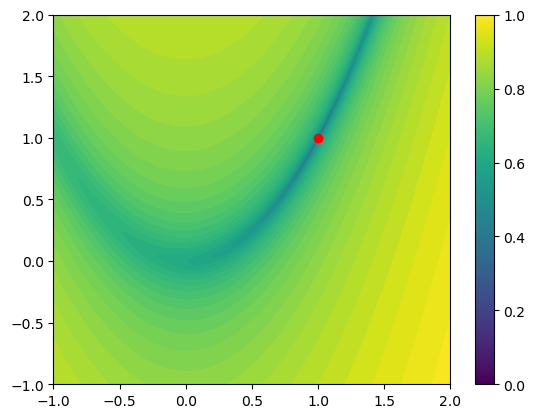

In [62]:
plt.contourf(X,Y,np.log((Z)), levels=50)
plt.scatter([1],[1], color="red")
plt.colorbar()
plt.show()

Method converged: False


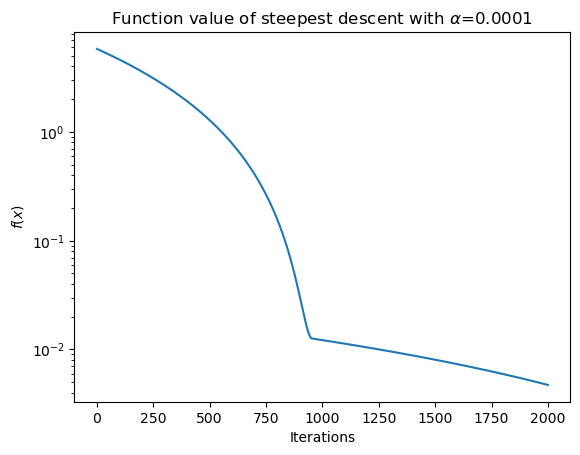

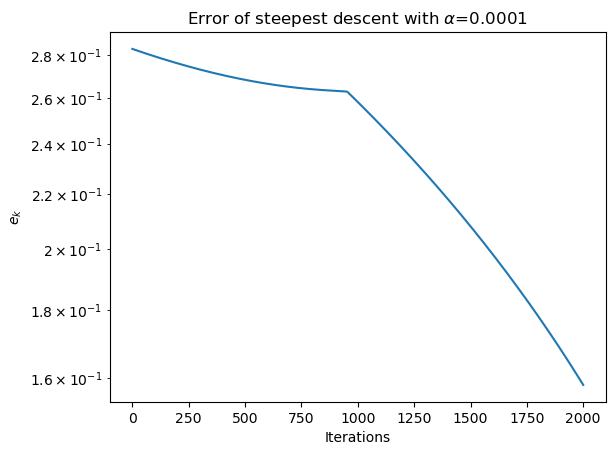

Method converged: False


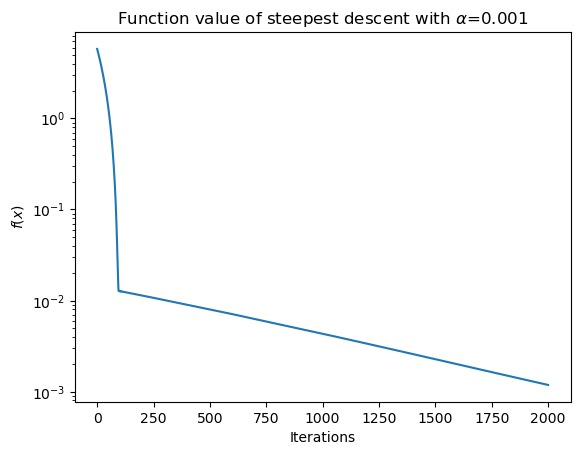

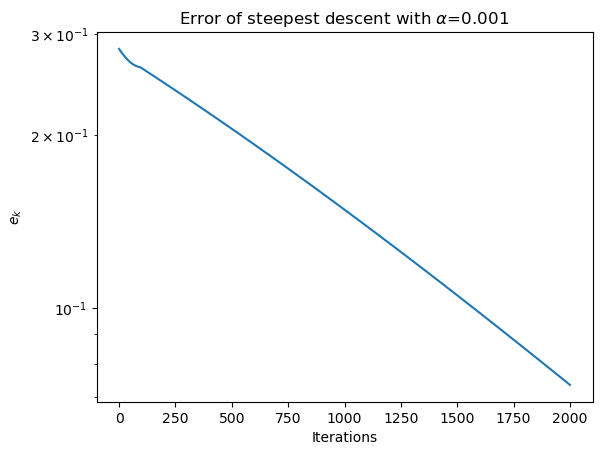

Method converged: False


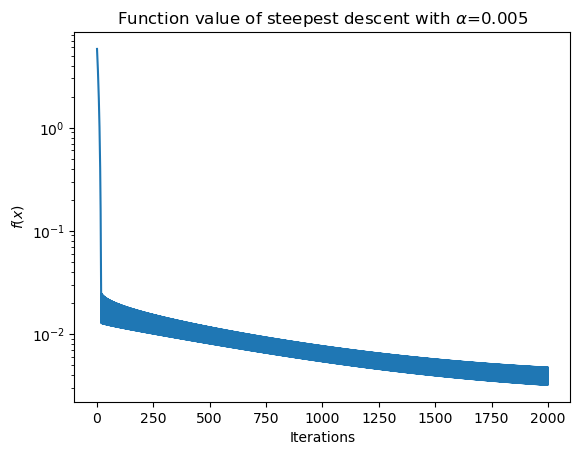

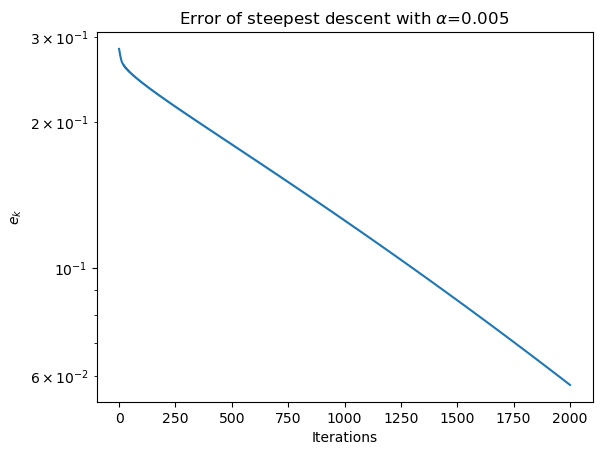

Method converged: False


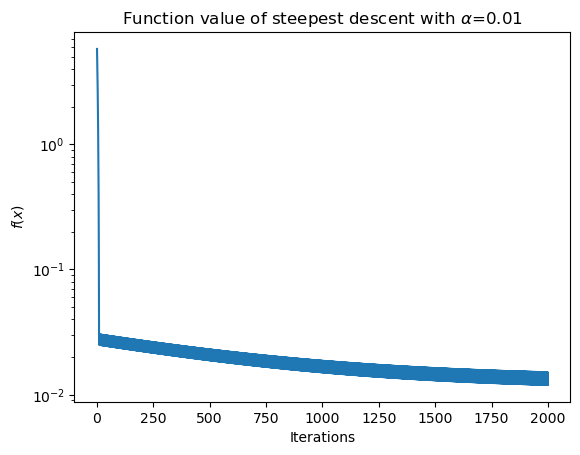

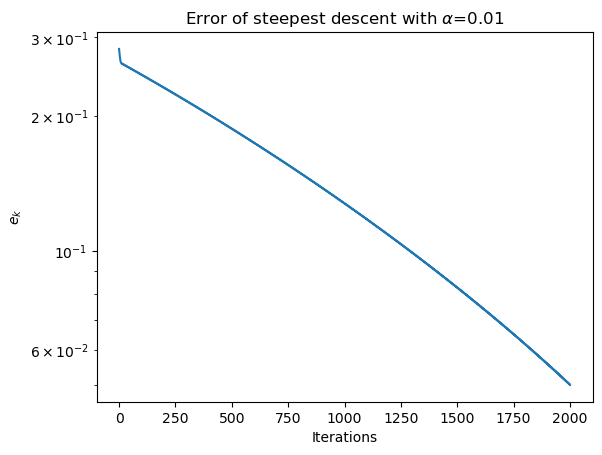

Method converged: False


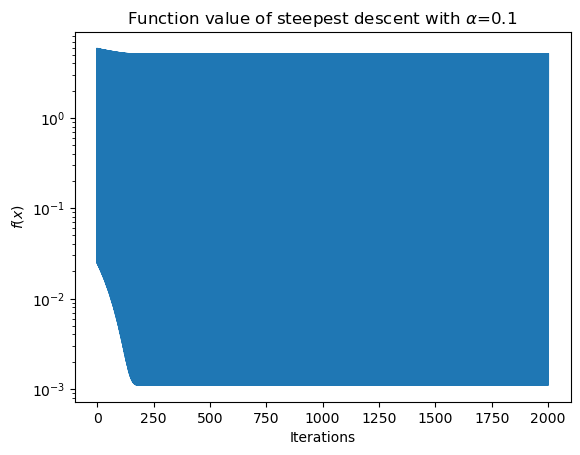

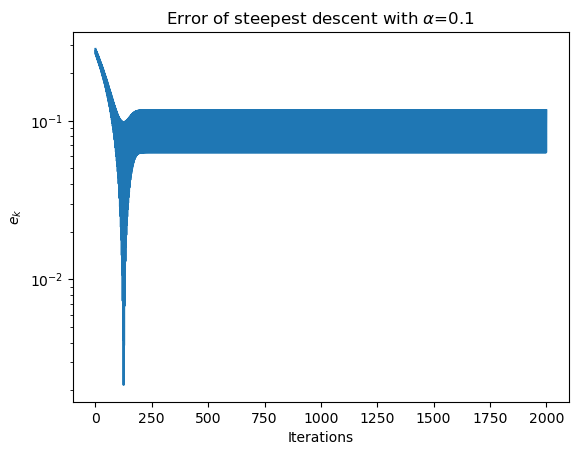

In [9]:
def steepest_descent(step_size: float, func: Callable, x0: Union[np.array, float], **kwargs):
    stats = {"converged": False,
             "function_calls": 1,
             "iterations": 0,
             "X": [],
             "F": [],
             "dF": [],
             "e": []}
    
    x = x0
    f, df, _ = func(x)
    
    x_star = np.array([1,1])
    
    
    stats["e"].append(np.linalg.norm(x-x_star))    
    stats["X"].append(x)
    stats["F"].append(f)
    stats["dF"].append(df)

    while (not stats["converged"] and stats["iterations"] < kwargs["max_iter"]):
        stats["iterations"] += 1
        
        x -= step_size * df / np.linalg.norm(df)
        
        f, df, _ = func(x)
        
        stats["converged"] = np.linalg.norm(df, ord=np.inf) <= kwargs["tol"]
        stats["function_calls"] += 1
        
        stats["e"].append(np.linalg.norm(x-x_star))
        stats["X"].append(x)
        stats["F"].append(f)
        stats["dF"].append(df)
        
    return x, stats


tol = 1e-10
step_sizes = [0.0001, 0.001, 0.005, 0.01, 0.1]
for step_size in step_sizes:
    x0 = np.array([1.2, 1.2])
    x, stats = steepest_descent(step_size, rosenbrock, x0, tol=tol, max_iter=2000)
    print(f"Method converged: {stats['converged']}")
    plt.semilogy(range(stats["iterations"]+1), stats["F"])
    plt.title(fr"Function value of steepest descent with $\alpha$={step_size}")
    plt.ylabel("$f(x)$")
    plt.xlabel("Iterations")
    plt.show()
    
    
    plt.semilogy(range(stats["iterations"]+1), stats["e"])
    plt.title(fr"Error of steepest descent with $\alpha$={step_size}")
    plt.ylabel("$e_k$")
    plt.xlabel("Iterations")
    plt.yscale("log")
    plt.show()
    plt.close()


Method converged: False


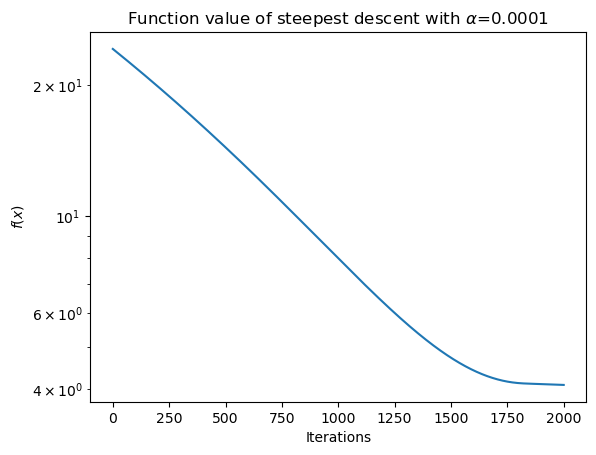

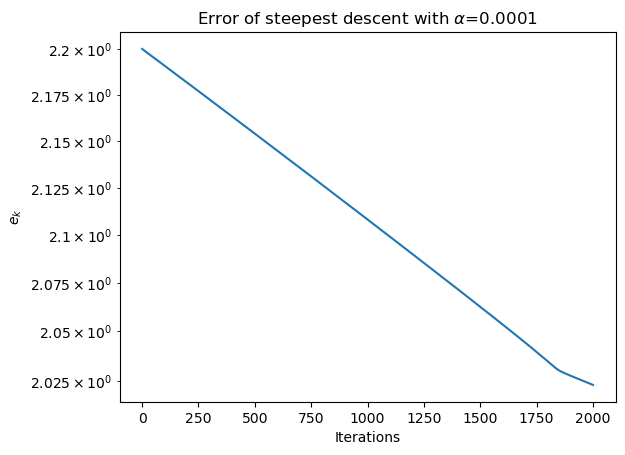

2.0227815454231917
Method converged: False


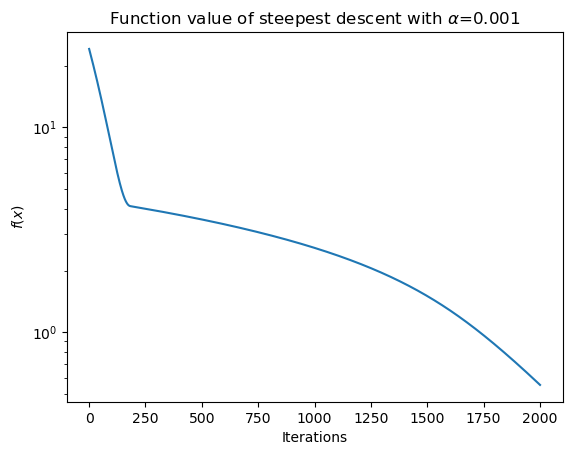

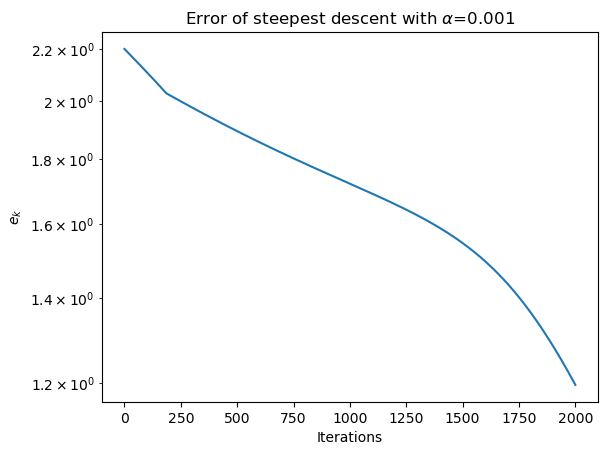

1.1951472517308839
Method converged: False


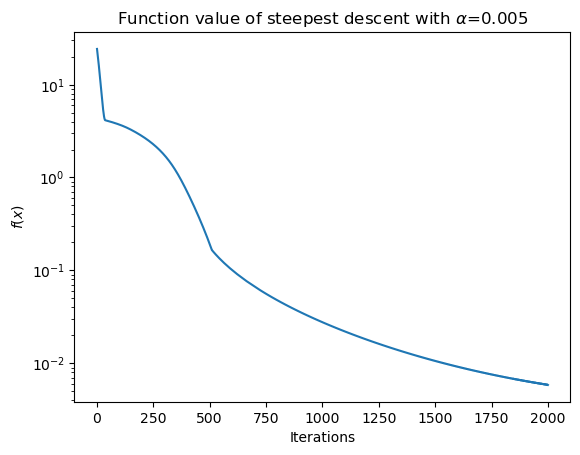

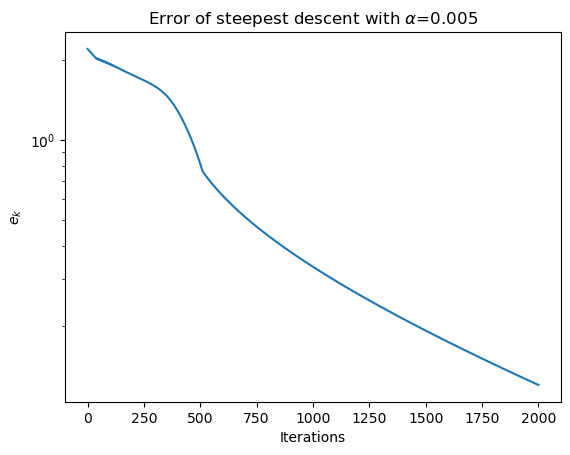

0.11979331377621218
Method converged: False


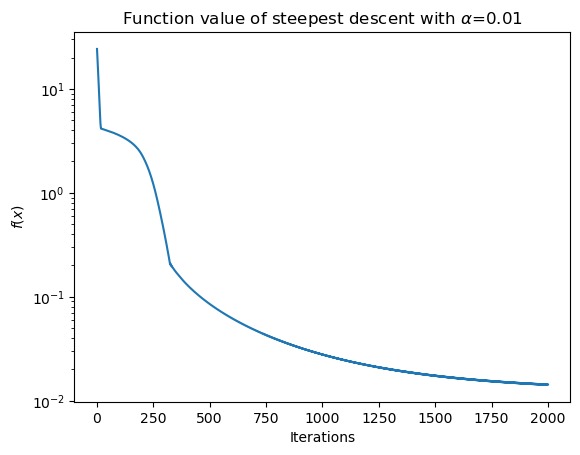

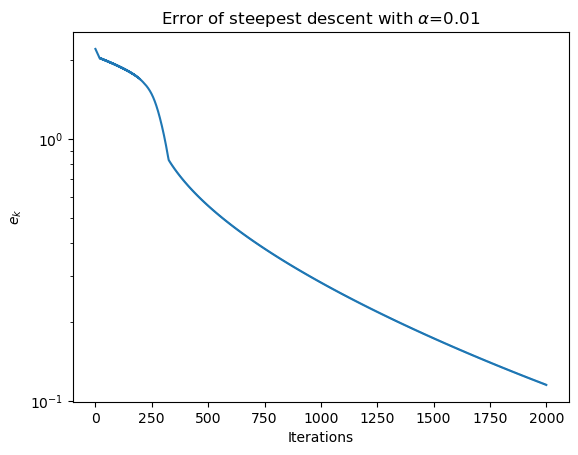

0.11494830535221935
Method converged: False


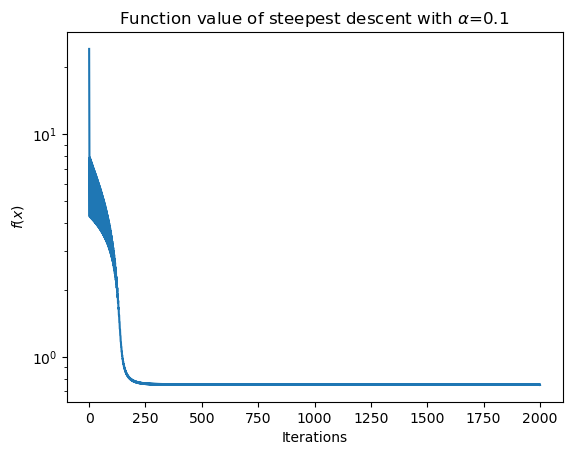

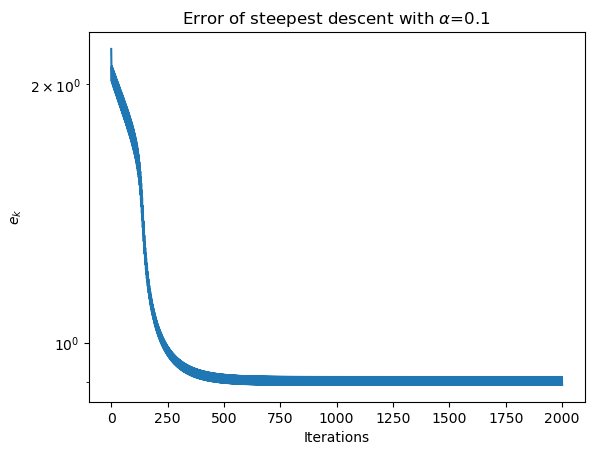

0.8941684998562281


In [10]:
tol = 1e-10
step_sizes = [0.0001, 0.001, 0.005, 0.01, 0.1]
for step_size in step_sizes:
    x0 = np.array([-1.2, 1])
    x, stats = steepest_descent(step_size, rosenbrock, x0, tol=tol, max_iter=2000)
    print(f"Method converged: {stats['converged']}")
    plt.semilogy(range(stats["iterations"]+1), stats["F"])
    plt.title(fr"Function value of steepest descent with $\alpha$={step_size}")
    plt.ylabel("$f(x)$")
    plt.xlabel("Iterations")
    plt.show()
    
    
    plt.semilogy(range(stats["iterations"]+1), stats["e"])
    plt.title(fr"Error of steepest descent with $\alpha$={step_size}")
    plt.ylabel("$e_k$")
    plt.xlabel("Iterations")
    plt.yscale("log")
    plt.show()
    plt.close()
    
    print(stats["e"][-1])

In [11]:
x, stats = steepest_descent(0.005, rosenbrock, np.array([1.2,1.2]), tol=tol, max_iter=2000)
print(np.linalg.norm(np.abs(x-np.array([1,1]))))
print(stats["converged"])
print(x)
print(stats["e"][-1], stats["F"][-1])

0.05744831062216967
False
[1.02286022 1.05270407]
0.05744831062216967 0.004697077410651419


In [15]:
rosenbrock_lambda = lambda x: 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
rosenbrock_grad_lambda = lambda x: np.array([-400*x[0]*(x[1] - x[0]**2) + 2 * x[0] - 2, 200*(x[1] - x[0] ** 2)])

In [50]:


def BFGS_line(x0: np.array, func: Callable, grad_f: Callable, iterations: int, **kwargs):
    """
    function must return (function value, gradient, hessian)
    """
    H = np.eye(len(x0))
    I = np.eye(len(x0))
    
    grad = grad_f(x0)
    
    x = x0
    
    xs = [x]
    ys = [func(x)]
    
    errors = [np.linalg.norm(x-kwargs["x_star"])]
    
    for k in range(iterations):
        grad = grad_f(x)
        
        
        p = -H @ grad
        
        
        alpha = backtrack(x, func, grad, p)
        
        next_x = x + alpha * p
        s = next_x - x
        y = grad_f(next_x) - grad
        
        if np.linalg.norm(grad, np.inf) <= kwargs["tol"]:
            break

        rho = 1 / np.dot(y, s)
        
        A = I - rho * np.outer(s, y)
        B = I - rho * np.outer(y, s)
        
        H = A @ H @ B + rho * np.outer(s, s)
        
        x = next_x
        
        xs.append(x)
        ys.append(func(x))
        errors.append(np.linalg.norm(x-kwargs["x_star"]))
    
    return xs, ys, errors, B
        
def backtrack(x, f, df, direction):
    alpha = 0.1
    c = 0.5
    rho = 0.8
    while f(x + alpha*direction) > (f(x) + c * alpha * df @ direction):
        alpha *= rho
    return alpha

x0 = np.array([1.2,1.2])
start = time.time()
x, y, e, B = BFGS_line(x0, func=rosenbrock_lambda, grad_f=rosenbrock_grad_lambda, iterations=2000, x_star=np.array([1,1]), tol=1e-10)
end = time.time()
print(end - start)
print((end - start)/len(x))


0.017003536224365234
7.204888230663235e-05


In [57]:
np.linalg.norm(B - rosenbrock([1,1])[2])

1000.7985665556795

In [22]:
print(6.36e-5 == 0.0000636)

True


In [49]:
e[-1]

1.5700687320523117e-11

In [47]:
e = np.array(e)

In [48]:
(np.log(e[2:] / e[1:-1]) / np.log(e[1:-1] / e[:-2]))[-235:]

array([-0.05036603, -7.09381235,  1.57473396,  1.11168529,  1.06783359,
        1.05306694,  1.04659741,  1.04252673,  1.03938054,  1.03674139,
        1.03444853,  1.03240632,  1.03054834,  1.02882835,  1.02721435,
        1.02568432,  1.02422327,  1.02282119,  1.02147162,  1.02017069,
        1.01891633,  1.01770772,  1.01654486,  1.01542827,  1.0143587 ,
        1.01333697,  1.01236381,  1.01143972,  1.01056499,  1.00973954,
        1.00896303,  1.00823475,  1.00755372,  1.00691867,  1.00632809,
        1.00578028,  1.00527336,  1.00480535,  1.00437419,  1.00397777,
        1.00361395,  1.00328063,  1.00297574,  1.00269725,  1.00244323,
        1.00221179,  1.00200121,  1.00180972,  1.00163589,  1.00147803,
        1.00133508,  1.00120524,  1.00108821,  1.00098139,  1.00088629,
        1.00079779,  1.00072203,  1.00064656,  1.00059019,  1.00051955,
        1.00048899,  1.00040559,  1.00042438,  1.00028286,  1.00042265,
        1.0000972 ,  1.00056689,  0.99970035,  1.00110276,  0.99

In [34]:
len(x)

236

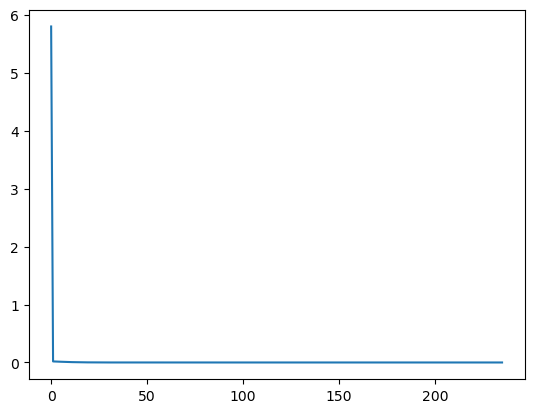

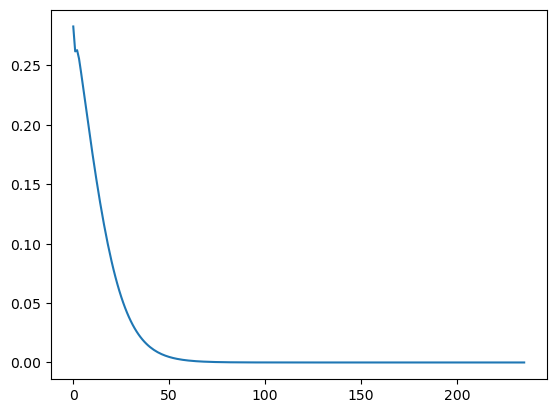

In [13]:
plt.plot(range(len(x)), y)
plt.show()

plt.plot(range(len(x)), e)
plt.show()

## Additional exercises

### 1 Convexity

We consider the function
$$f(x_1,x_2)=x_1x_2$$
on $\mathbb{R}_{++}^2$ and wish to determine whether it is convex or concave

We start by computing the Hessian, starting with the gradient

$$\nabla f = \begin{bmatrix}x_2\\x_1\end{bmatrix}\\\nabla^2 f = \begin{bmatrix}0 & 1\\1&0\end{bmatrix}$$

The 



### 2 Stationary points and steepest descent method

We now consider the function
$$f(\boldsymbol{x}) = f_1(\boldsymbol{x})^2 + f_2(\boldsymbol{x})^2$$
where
$$f_1(\boldsymbol{x})=x_1+x_2^2-1\\
  f_2(\boldsymbol{x})=x_1+3$$
  
So we have
$$f(\boldsymbol x)=(x_1+x_2^2-1)^2 + (x_1 + 3)^2$$
which expands to
$$f(\boldsymbol x)=x_2^4+2x_1x_2^2+2x_1^2-2x_2^2+4x_1+10.$$
We can now compute the gradient and Hessian

$$\nabla f(\boldsymbol x) = \begin{bmatrix}2(x_1+x_2^2-1) + 2(x_1+3)\\ 4x_2(x_1+x_2^2-1)\end{bmatrix}\\
  \nabla^2 f(\boldsymbol x) = \begin{bmatrix}4 & 4x_2\\ 4x_2 & 12x_2^2+4x_1-4\end{bmatrix}$$

If we let $x_2=0$ we have
$$4x_2(x_1+x_2^2-1) = 0$$
so we need to solve
$$2(x_1-1)+2(x_1+3)=0$$
for $x_1$ which yields $x_1=-1$ giving us the first stationary point
$$\boldsymbol x_1^* = [-1, 0]^\top$$

Next we let $x_1=-3$ such that $2(x_1+3)=0$ with this we need $x_2^2-4=0$, which holds for $x_2=\pm 2$ giving us the two last remaining stationary points
$$\boldsymbol x_2^* = [-3, 2]^\top\\\boldsymbol x_3^* = [-3, -2]^\top$$


At $\boldsymbol x_1^*$ the Hessian is
$$\nabla^2 f(\boldsymbol x_1^*)=\begin{bmatrix}4 & 0\\0&-8\end{bmatrix}$$
which shows that $\boldsymbol x_1^*$ is a saddle point, since the eigenvalues are in the diagonal.

For $\boldsymbol x_2^*$ the Hessian is
$$\nabla^2 f(\boldsymbol x_2^*)=\begin{bmatrix}4 & 8\\8 & 32\end{bmatrix}$$

and lastly for $\boldsymbol x_3^*$ the Hessian is
$$\nabla^2 f(\boldsymbol x_3^*)=\begin{bmatrix}4 & -8\\-8 & 32\end{bmatrix}$$

The Hessian of both $\boldsymbol x_2^*$ and $\boldsymbol x_3^*$ have eigenvalues 
$$\lambda =\cfrac{36\pm\sqrt{36^2-256}}{2}$$
The value of the square root is less than 36 from which we can conclude that both eigenvalues are positive and as such we know that they are at least local minimizers.

Inspecting the function value at $\boldsymbol x_2^*$ and $\boldsymbol x_3^*$ we get

$$f(\boldsymbol x_2^*)=(x_1+x_2^2-1)^2+(x_1+3)^2=0^2+0^2=0$$
and
$$f(\boldsymbol x_3^*)=(x_1+x_2^2-1)^2+(x_1+3)^2=0^2+0^2=0$$,

since they are of the same function value, $\boldsymbol x_2^*$ and $\boldsymbol x_3^*$ are global minimizers as there are no other stationary points left.

In [148]:
def f3(x: np.array):
    return (x[0] + x[1]**2 - 1) ** 2 + (x[0] + 3) ** 2,\
            np.array([2*(x[0]+x[1]**2-1)+2*(x[0]+3), 4*x[1]*(x[0]+x[1]**2-1)]), ""

x0s = [np.array([-2, -1]), np.array([-2, 0]), np.array([-2, 1])]

for x0 in x0s:
    x, stat = steepestdescent_line(f3, x0, tol=1e-5, rho=0.5, c=0.5)
    print(f"Algorithm converged to x={x} in {stat['iter']} iterations")

Algorithm converged to x=[-2.99999583 -1.99999898] in 54 iterations
Algorithm converged to x=[-1.  0.] in 1 iterations
Algorithm converged to x=[-2.99999583  1.99999898] in 54 iterations


Using steepest descent with backtracking line search as specified in the assignment for the first starting point the algorithm converges to
$$\boldsymbol x^*=[-3, -2]^\top$$ in 54 iterations. For the second starting point the algorithm converges to the saddle point
$$\boldsymbol x^*=[-1, 0]^\top$$ in a single iteration and lastly for the third starting point the algorithm converges to the last minimizer at $\boldsymbol x^*=[-3, 2]^\top$ in 54 iterations once again.

In [140]:
import numpy as np

def steepestdescent_line(func, x0, tol=1.0e-10, maxit=None, rho=0.5, c=0.1, *args):
    # Solver settings and info
    maxit = maxit if maxit is not None else 100*len(x0)
    
    # Initialize
    stat = {"converged": False, "nfun": 0, "iter": 0, "alpha": [], "X": [x0], "F": [], "dF": []}
    x = np.copy(x0)
    it = 0
    f, df, _ = func(x, *args)
    converged = (np.linalg.norm(df, np.inf) <= tol)
    stat["nfun"] += 1
    
    # Store data for plotting
    stat["F"].append(f)
    stat["dF"].append(df)
    
    # Main loop of steepest descent
    while not converged and (it < maxit):
        it += 1
        
        p = - df / np.linalg.norm(df, 2)
        
        # backtracking line search
        alpha = 1
        fnew, _, _ = func(x + alpha * p, *args)
        while fnew > (f + c * alpha * np.dot(df.T, p)):
            alpha = rho * alpha
            fnew, _, _ = func(x + alpha * p, *args)
        stat["alpha"].append(alpha)
        
        x = x + alpha * p
        f, df, _ = func(x, *args)
        converged = (np.linalg.norm(df, np.inf) <= tol)
        stat["nfun"] += 1
        
        # Store data for plotting
        stat["X"].append(np.copy(x))
        stat["F"].append(f)
        stat["dF"].append(df)
    
    # Prepare return data
    if not converged:
        x = [] 
    stat["converged"] = converged
    stat["iter"] = it
    
    return x, stat


def f3(x: np.array):
    return (x[0] + x[1]**2 - 1) ** 2 + (x[0] + 3) ** 2,\
            np.array([2*(x[0]+x[1]**2-1)+2*(x[0]+3), 4*x[1]*(x[0]+x[1]**2-1)]), ""

x0s = [np.array([-2, -1]), np.array([-2, 0]), np.array([-2, 1])]

for x0 in x0s:
    x, stat = steepestdescent_line(f3, x0, tol=1e-5, rho=0.5, c=0.5)
    print(x)
    print(stat["iter"])

[-2.99999583 -1.99999898]
54
[-1.  0.]
1
[-2.99999583  1.99999898]
54
